In [2]:
!pip install lpips
!pip install torchmetrics
!pip install --upgrade pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 13.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# some imports
import numpy as np
import torch
import torch.nn as nn
from scipy.ndimage import laplace, sobel
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFilter
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import lpips
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from torchvision.transforms.functional import to_pil_image



from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
class SineLayer(nn.Module):

    """ Linear layer followed by the sine activation

    If `is_first == True`, then it represents the first layer of the network.
    In this case, omega_0 is a frequency factor, which simply multiplies the activations before the nonlinearity.
    Note that it influences the initialization scheme.

    If `is_first == False`, then the weights will be divided by omega_0 so as to keep the magnitude of activations constant,
    but boost gradients to the weight matrix.
    """

    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        # Initialize a linear layer with specified input and output features
        # 'bias' indicates whether to include a bias term
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    # initialize weights uniformly
    def init_weights(self):
        # diasble gradient calculation in initialization
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        # Task 1 TODO
        # 1. pass input through linear layer (self.linear layer performs the linear transformation on the input)

        # 2. scale the output of the linear transformation by the frequency factor

        # 3. apply sine activation

        return torch.sin(self.omega_0 * self.linear(input))


In [6]:
class Siren(nn.Module):
    """ SIREN architecture """

    def __init__(self, in_features, out_features, hidden_features=256, hidden_layers=3, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        # add the first layer
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        # append hidden layers
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))


        if outermost_linear:
            # add a final Linear layer
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad(): # weights intialization
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            # otherwise, add a SineLayer
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net) # sequential wrapper of SineLayer and Linear

    def forward(self, coords):
        # coords represents the 2D pixel coordinates
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

In [7]:
def get_mgrid(sidelen1,sidelen2, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''

    if sidelen1 >= sidelen2:
      # use sidelen1 steps to generate the grid
      tensors = tuple(dim * [torch.linspace(-1, 1, steps = sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim = -1)
      # crop it along one axis to fit sidelen2
      minor = int((sidelen1 - sidelen2)/2)
      mgrid = mgrid[:,minor:sidelen2 + minor]

    if sidelen1 < sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps = sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim = -1)

      minor = int((sidelen2 - sidelen1)/2)
      mgrid = mgrid[minor:sidelen1 + minor,:]

    # flatten the gird
    mgrid = mgrid.reshape(-1, dim)

    return mgrid

In [8]:
def image_to_tensor(img):
    transform = Compose([
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img


In [9]:
# Image Fitting Dataloader
class ImageData(Dataset):
    def __init__(self, img):
        super().__init__()

        # convert the image to a tensor with transformations
        img = image_to_tensor(img)

        self.pixels = img.permute(1, 2, 0).reshape(-1, 3) # pixel values of the org img

        # create a grid of coordinates for the image
        self.coords = get_mgrid(img.shape[1], img.shape[2], 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [10]:
# define differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [11]:

# Creating and Applying Blurring Kernels
# util: https://github.com/GaryMataev/DeepRED
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function (Creates a Gaussian blurring kernel)
    """
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()

def get_fft_h(im, blur_type):
    """Computes the Fourier transform of a blurring kernel
    """
    assert blur_type in ['uniform_blur', 'gauss_blur'], "blur_type can be or 'uniform' or 'gauss'"
    ch, h, w = im.shape
    fft_h    =  np.zeros((h,w),)
    if blur_type=='uniform_blur':
        t        =  4 # 9//2
        fft_h[h//2-t:h//2+1+t, w//2-t:w//2+1+t]  = 1/81
        fft_h    = np.fft.fft2(np.fft.fftshift(fft_h))
    else: # gauss_blur
        psf = fspecial_gauss(25, 1.6)
        t = 12 # 25 // 2
        fft_h[h//2-t:h//2+1+t, w//2-t:w//2+1+t]  = psf
        fft_h    =  np.fft.fft2(np.fft.fftshift(fft_h))
    return fft_h

def blur(im, blur_type):
    """Apply blur kernel to the input image
    """
    fft_h = get_fft_h(im, blur_type)
    imout = np.zeros_like(im)
    for i in range(im.shape[0]):
        im_f    =  np.fft.fft2(im[i, :, :])
        z_f     =  fft_h*im_f # .* of matlab
        z       =  np.real(np.fft.ifft2(z_f))
        imout[i, :, :] = z
    return imout


# - the inverse function H -
def get_h(n_ch, blur_type, use_fourier, dtype):
    assert blur_type in ['uniform_blur', 'gauss_blur'], "blur_type can be or 'uniform' or 'gauss'"
    if not use_fourier:
        return Downsampler(n_ch, 1, blur_type, preserve_size=True).type(dtype)
    return lambda im: torch_blur(im, blur_type, dtype)


def torch_blur(im, blur_type, dtype):
  # blur an image tensor
    fft_h = get_fft_h(torch_to_np(im), blur_type)
    fft_h_torch = torch.unsqueeze(torch.from_numpy(np.real(fft_h)).type(dtype), 2)
    fft_h_torch = torch.cat([fft_h_torch, fft_h_torch], 2)
    z = []
    for i in range(im.shape[1]):
        im_torch = torch.unsqueeze(im[0, i, :, :], 2)
        im_torch = torch.cat([im_torch, im_torch], 2)
        im_f    =  torch.fft(im_torch, 2)
        z_f     =  torch.mul(torch.unsqueeze(fft_h_torch, 0), torch.unsqueeze(im_f, 0)) # .* of matlab
        z.append(torch.ifft(z_f, 2))
    z = torch.cat(z, 0)
    return torch.unsqueeze(z[:, :, :, 0], 0)


In [12]:

class Downsampler(nn.Module):
    """
        Resampling filters
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    """

    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None,
                 preserve_size=False, pad_type='reflection', transpose_conv=False):
        super(Downsampler, self).__init__()

        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1 / 2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1. / np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type == 'uniform_blur':
            kernel_width = 9
            kernel_type_ = 'uniform'
            pad_type = 'circular'

        elif kernel_type == 'gauss_blur':
            kernel_width = 25
            sigma = 1.6
            kernel_type_ = 'gauss'
            pad_type = 'circular'

        elif kernel_type in {'lanczos', 'gauss', 'box'}:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'

        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        if transpose_conv:
            if self.kernel.shape[0] % 2 == 1:
                pad = int((self.kernel.shape[0] - 1) // 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) // 2.)
            downsampler = nn.ConvTranspose2d(n_planes, n_planes, kernel_size=self.kernel.shape,
                                             stride=factor, padding=pad)
        else:
            downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch

        self.downsampler_ = downsampler

        if preserve_size:
            if pad_type=='circular':
                self.padding = lambda torch_in: pad_circular(torch_in, kernel_width // 2)
            elif pad_type=='reflection':
                if self.kernel.shape[0] % 2 == 1:
                    pad = int((self.kernel.shape[0] - 1) // 2.)
                else:
                    pad = int((self.kernel.shape[0] - factor) // 2.)
                self.padding = nn.ReplicationPad2d(pad)
            else:
                assert False, "pad_type have only circular or reflection options"
        self.preserve_size = preserve_size

    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x = input
        self.x = x
        return self.downsampler_(x)


def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box', 'uniform', 'blur']

    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box':
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])

    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1. / (kernel_width * kernel_width)

    elif kernel_type == 'gauss':
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        return fspecial_gauss(kernel_width, sigma)

    elif kernel_type == 'uniform':
        kernel = np.ones([kernel_width, kernel_width])

    elif kernel_type == 'lanczos':
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):#print metrics

                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor
                    dj = abs(j + 0.5 - center) / factor
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor

                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)

                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                kernel[i - 1][j - 1] = val
    else:
        assert False, 'wrong method name'
    kernel /= kernel.sum()
    return kernel


def pad_circular(x, pad):
    """
    :param x: pytorch tensor of shape: [batch, ch, h, w]
    :param pad: uint
    :return:
    """
    x = torch.cat([x, x[:, :, 0:pad]], dim=2)
    x = torch.cat([x, x[:, :, :, 0:pad]], dim=3)
    x = torch.cat([x[:, :, -2*pad:-pad], x], dim=2)
    x = torch.cat([x[:, :, :, -2*pad:-pad], x], dim=3)
    return x


In [13]:
# get downsampler x8
blur_type = 'box'
downsampler = Downsampler(n_planes=3, factor=8, kernel_type=blur_type, phase=0.5, kernel_width=8, preserve_size=True).to(device)

In [14]:


def add_gaussian_noise(image, sigma):
    """
    Adds Gaussian noise to a PIL image.

    Args:
        image (PIL.Image.Image): Input image (PIL format).
        sigma (float): Standard deviation of the Gaussian noise.

    Returns:
        Tuple[PIL.Image.Image, np.ndarray]: Noisy image in PIL format and as a NumPy array.
    """
    # Convert PIL image to NumPy array
    img_np = np.array(image).astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Generate Gaussian noise
    noise = np.random.normal(scale=sigma / 255.0, size=img_np.shape).astype(np.float32)

    # Add noise to the image and clip values to [0, 1]
    img_noisy_np = np.clip(img_np + noise, 0, 1)

    # Convert back to PIL image
    img_noisy_pil = Image.fromarray((img_noisy_np * 255).astype(np.uint8))

    return img_noisy_pil, img_noisy_np



Width: 2040, Height: 1152
Width_lr: 2040, Height_lr: 1152


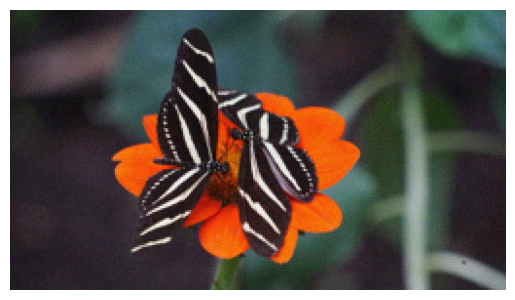

In [15]:
# Helper function to resize the image
def resize_image(img_pil, target_size):
    return img_pil.resize(target_size, Image.NEAREST)

#img_index = '0465'
#img_index = '0170'
#img_index = '0025'
img_index = '0185'
#img_index = '0745'
out_path = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/SIREN_OUTPUT_NOISE/' + img_index + '/'
fname_hr = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIV2K_train_HR/' + img_index + '.png'
fname_lr = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/DIV2K_train_LR_x8/' + img_index + 'x8.png'

image_hr = Image.open(fname_hr)
image_lr = Image.open(fname_lr)

# Get width and height
width, height = image_hr.size
print(f"Width: {width}, Height: {height}")

image_lr = resize_image(image_lr, (width, height))
width_lr, height_lr = image_lr.size
print(f"Width_lr: {width_lr}, Height_lr: {height_lr}")


noise_var = 25 # sigma <--- left
#noise_var = 40 # sigma
#noise_var = 60 # sigma

image_lr_noisy, image_lr_noisy_np = add_gaussian_noise(image_lr, noise_var)
# Display the image with Matplotlib
plt.imshow(image_lr_noisy)
plt.axis("off")  # Hide axes
plt.show()

(-0.5, 2039.5, 1151.5, -0.5)

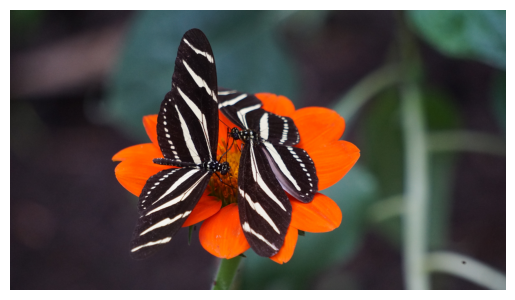

In [16]:
plt.imshow(np.array(image_hr))
plt.axis('off')

(-0.5, 2039.5, 1151.5, -0.5)

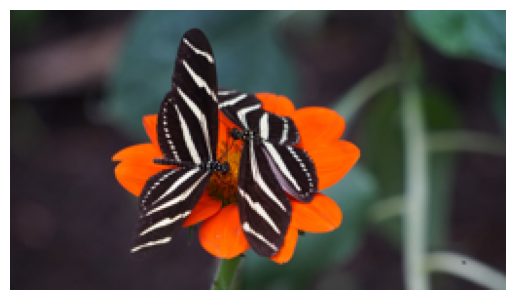

In [17]:
plt.imshow(np.array(image_lr))
plt.axis('off')

(-0.5, 2039.5, 1151.5, -0.5)

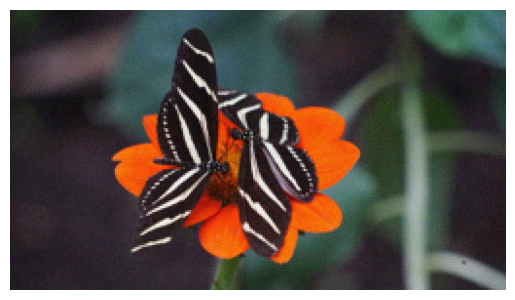

In [18]:
plt.imshow(np.array(image_lr_noisy))
plt.axis('off')

In [19]:
celeb_lr = ImageData(image_lr_noisy)
dataset_lr = DataLoader(celeb_lr, batch_size=1, pin_memory=True, num_workers=0)

celeb_hr = ImageData(image_hr)
dataset_hr = DataLoader(celeb_hr, batch_size=1, pin_memory=True, num_workers=0)

lpips_loss_fn = lpips.LPIPS(net='alex').to(device)
# create a siren model ready for deblurring
img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=6, outermost_linear=True)
img_siren.to(device)

total_steps = 2000
steps_til_summary = 200

#optim = torch.optim.Adam(lr=0.0001, params=img_siren.parameters(), weight_decay=1e-5)
optim = torch.optim.Adam(lr=0.0001, params=img_siren.parameters())

# Initialize learning rate scheduler

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    mode='min',     # Because we're minimizing the loss
    factor=0.75,     # Factor by which the learning rate will be reduced
    patience=100,   # Number of epochs with no improvement after which learning rate will be reduced
    verbose=True    # Prints a message when the learning rate is reduced
)


model_input, ground_truth = next(iter(dataset_lr))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

hr_gt_img, hr_ground_truth = next(iter(dataset_hr))
hr_gt_img, hr_ground_truth = hr_gt_img.cuda(), hr_ground_truth.cuda()

#psnr
input_image_lr_np = np.array(image_lr_noisy).astype(np.float32) / 255.0
input_image_hr_np = np.array(image_hr).astype(np.float32) / 255.0

psnr_history = []

for step in range(total_steps):
    model_output, coords = img_siren(model_input)

    model_output_img = model_output.view(1, height, width, 3).permute(0, 3, 1, 2)  # Reshape to image format
    model_output_downsampled = downsampler(model_output_img)  # Apply downsampling
    model_output_upsampled = F.interpolate(model_output_downsampled, size=(height, width), mode='nearest')  # Upsample
    model_outputnew = model_output_upsampled.permute(0, 2, 3, 1).view(1, -1, 3)  # Reshape back to original format

    loss = ((model_outputnew - ground_truth)**2).mean()

    if (not step % steps_til_summary) or step==total_steps-1:
        with torch.no_grad():
            print("Step %d, Total loss %0.6f" % (step, loss))
            print(scheduler.optimizer.param_groups[0]['lr'])


            # Prepare ground truth image in correct format
            hr_ground_truth_img = hr_ground_truth.view(1, height, width, 3).permute(0, 3, 1, 2).to(device)
            # Ensure images are on the same device
            model_output_img = model_output_img.to(device)
            # Scale images to [0, 1] for SSIM
            model_output_img_01 = (model_output_img + 1) / 2
            hr_ground_truth_img_01 = (hr_ground_truth_img + 1) / 2
            # Compute SSIM
            ssim_value = ssim(model_output_img_01, hr_ground_truth_img_01, data_range=1.0, size_average=True)
            # Compute LPIPS
            lpips_value = lpips_loss_fn(model_output_img, hr_ground_truth_img)

            # 2. Get the output image (high-resolution) as a NumPy array:
            output_image_np = model_output_img_01.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

            output_image_lr_np = model_output_upsampled.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
            output_image_lr_np = (output_image_lr_np + 1) / 2  # Scale to [0, 1]

            psnr_LR = compare_psnr(input_image_lr_np, output_image_lr_np)
            psnr_HR = compare_psnr(input_image_hr_np, output_image_np)

            print('Step:', step, 'PSNR_LR:', psnr_LR, 'PSNR_HR:', psnr_HR,
                  'SSIM:', ssim_value.item(), 'LPIPS:', lpips_value.item())

            # History
            psnr_history.append([step, psnr_LR, psnr_HR, loss.item(), ssim_value.item(), lpips_value.item()])

            model_output = (model_output + 1) / 2  # Convert output to [0, 1]
            model_output = model_output.clamp(0, 1)  # Clip
            output = model_output.cpu().view(height, width, 3).detach().numpy()

            fig, axes = plt.subplots(1, 1, figsize=(12, 4))
            axes.imshow(output)
            plt.show()


    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step(loss)



Output hidden; open in https://colab.research.google.com to view.

In [20]:
def visualize_images_at_the_end(model_output, title1="Siren for Super Res output", title2="Original Hi Res img", title3="Low Res Siren Input img", save_path=None):
  """Visualizes two images: model_output and model_output_downsampled.

  Args:
    model_output: The first image tensor, assumed to be in shape (1, 3, height, width).
    model_output_downsampled: The second image tensor, assumed to be in shape (1, 3, height_lr, width_lr).
    title1: Title for the first image plot. Defaults to "model_output".
    title2: Title for the second image plot. Defaults to "model_output_downsampled".
  """

  # Process and display model_output
  model_output_image = model_output.detach().cpu().squeeze(0).permute(1, 2, 0)
  model_output_image = (model_output_image + 1) / 2
  model_output_image = model_output_image.clamp(0, 1)



  plt.figure(figsize=(15, 15))  # Adjust figure size if needed
  plt.subplot(3, 1, 1)  # Create a subplot for the second image
  plt.imshow(np.array(image_hr))
  plt.title(title2)
  plt.axis('off')

  plt.subplot(3, 1, 2)  # Create a subplot for the first image
  plt.imshow(model_output_image)
  plt.title(title1)
  plt.axis('off')


  plt.subplot(3, 1, 3)  # Create a subplot for the second image
  plt.imshow(image_lr_noisy_np)
  plt.title(title3)
  plt.axis('off')

  if save_path:
    plt.savefig(save_path, format='png', bbox_inches='tight')
    print(f"Plot saved as: {save_path}")


  plt.show()

Plot saved as: /content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/SIREN_OUTPUT_NOISE/0185/output_image_grid_0185_noise_25.png


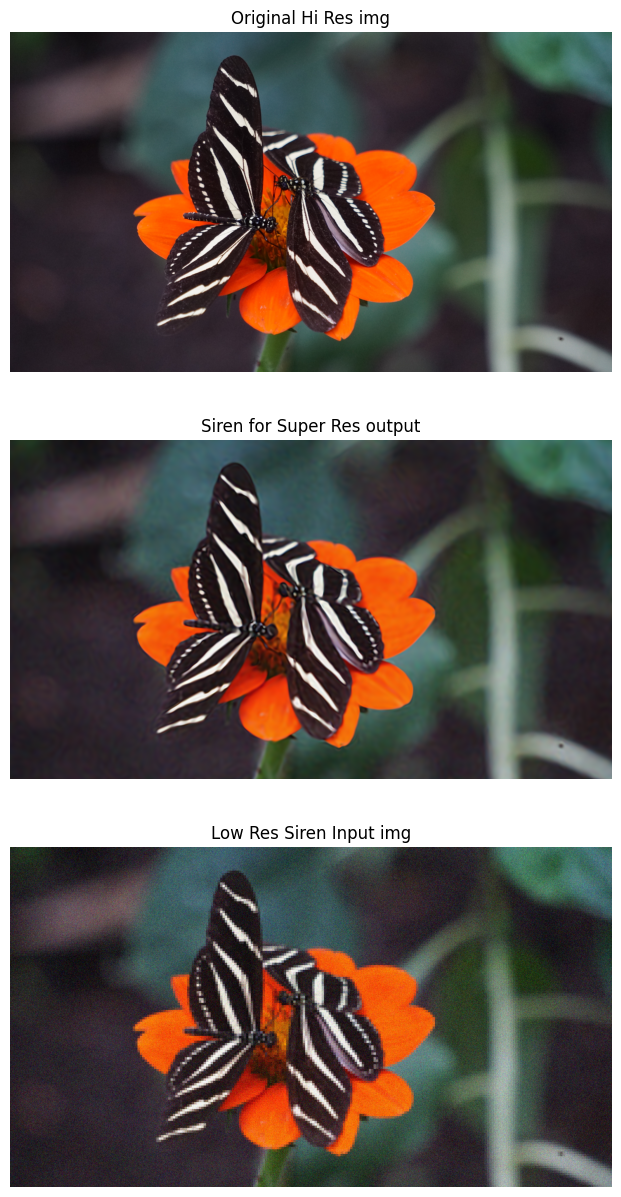

In [21]:
model_output_img_01 = (model_output_img + 1) / 2
out_path = '/content/drive/MyDrive/ColabNotebooks/AdvancedVisualAI/AVAI_COURSEWORK/avai-coursework/SIREN_OUTPUT_NOISE/' + img_index + '/'
sv_path = out_path + 'output_image_' + img_index + '_noise_' + str(noise_var) + '.png'

save_image(model_output_img_01, sv_path)

sv_path = out_path + 'output_image_grid_' + img_index + '_noise_' + str(noise_var) + '.png'
visualize_images_at_the_end(model_output_img, save_path=sv_path)

PSNR History (Iteration-wise):
Step 0 - PSNR_LR: 9.588, PSNR_HR: 9.740, loss: 0.439807 ssim: 0.5712353587150574 lpips: 0.7088379859924316
Step 200 - PSNR_LR: 20.504, PSNR_HR: 27.560, loss: 0.035615 ssim: 0.8674560785293579 lpips: 0.3472345173358917
Step 400 - PSNR_LR: 20.591, PSNR_HR: 28.442, loss: 0.034908 ssim: 0.8684172630310059 lpips: 0.3392089009284973
Step 600 - PSNR_LR: 20.653, PSNR_HR: 29.202, loss: 0.034416 ssim: 0.8761640787124634 lpips: 0.34013161063194275
Step 800 - PSNR_LR: 20.671, PSNR_HR: 29.466, loss: 0.034270 ssim: 0.8795206546783447 lpips: 0.3434015214443207
Step 1000 - PSNR_LR: 20.677, PSNR_HR: 29.545, loss: 0.034225 ssim: 0.8737091422080994 lpips: 0.3489779233932495
Step 1200 - PSNR_LR: 20.679, PSNR_HR: 29.525, loss: 0.034208 ssim: 0.8789743781089783 lpips: 0.3558337688446045
Step 1400 - PSNR_LR: 20.689, PSNR_HR: 29.616, loss: 0.034133 ssim: 0.8891484141349792 lpips: 0.36304134130477905
Step 1600 - PSNR_LR: 20.678, PSNR_HR: 29.444, loss: 0.034219 ssim: 0.87495565414

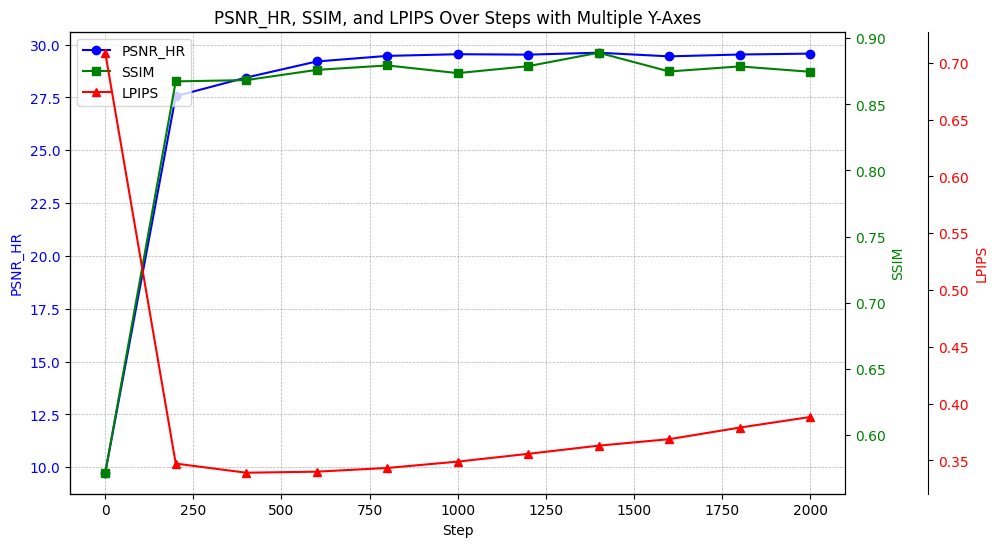

In [22]:
# lr = 0.0001 * 0.8
# weight decay = 0.00001
print("PSNR History (Iteration-wise):")

steps = []
psnr_hrs = []
ssims = []
lpipss = []

for idx, (step, psnr_LR, psnr_HR, loss, ssim, lpips) in enumerate(psnr_history):
    steps.append(step)
    psnr_hrs.append(psnr_HR)
    ssims.append(ssim)
    lpipss.append(lpips)
    print(f"Step {step} - PSNR_LR: {psnr_LR:.3f}, PSNR_HR: {psnr_HR:.3f}, loss: {loss:.6f}", "ssim:", ssim, "lpips:", lpips)
    save_path = out_path + 'eval_qual_metrics_' + img_index + '_noise_' + str(noise_var) + '.txt'
    with open(save_path, "a") as file:
        file.write(f"Step {step} - PSNR_LR: {psnr_LR:.3f}, PSNR_HR: {psnr_HR:.3f}, loss: {loss:.6f}, ssim:, {ssim:.6f}, lpips:, {lpips:.6f}, \n")

import matplotlib.pyplot as plt

# Sample data (replace with your actual data)

# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PSNR_HR on the primary y-axis
ax1.plot(steps, psnr_hrs, 'b-o', label='PSNR_HR')
ax1.set_xlabel('Step')
ax1.set_ylabel('PSNR_HR', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for SSIM
ax2 = ax1.twinx()
ax2.plot(steps, ssims, 'g-s', label='SSIM')
ax2.set_ylabel('SSIM', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Create a tertiary y-axis for LPIPS
# Offset the spine to make room for the third axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(steps, lpipss, 'r-^', label='LPIPS')
ax3.set_ylabel('LPIPS', color='r')
ax3.tick_params(axis='y', labelcolor='r')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

# Add a grid for better readability
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Set the title
plt.title('PSNR_HR, SSIM, and LPIPS Over Steps with Multiple Y-Axes')
save_path = out_path + 'plot_' + img_index + '_noise_' + str(noise_var) + '.png'

plt.savefig(save_path, format='png', bbox_inches='tight')
print(f"Plot saved as: {save_path}")

# Show the plot0465
plt.show()


In [23]:


def resize_image_bicubic(img_pil, target_size):
    return img_pil.resize(target_size, Image.BICUBIC)

#image_lr_test = Image.open(fname_lr)
input_image_hr_np = np.array(image_hr).astype(np.float32) / 255.0
image_lr_test = resize_image_bicubic(image_lr_noisy, (width, height))
#image_lr_test = np.array(image_lr_test)
image_lr_test = np.array(image_lr_test).astype(np.float32) / 255.0  # Normalize to [0, 1]

# Compute PSNR
psnr_value = compare_psnr(input_image_hr_np, image_lr_test)



save_path = out_path + 'eval_qual_metrics_' + img_index + '_noise_' + str(noise_var) + '.txt'

# Save the result to a text file
with open(save_path, "a") as file:  # "a" mode appends to the file if it exists
    file.write(f"BICUBIC: {psnr_value:.6f}\n")

# Optional: Print to console as well
print('BICUBIC:', psnr_value)

BICUBIC: 19.42914469934646
